# Trabajo Práctico 2

#### Algunas anotaciones
usar un perceptrón simple = 1

El bias es un parámetro mas que es optimizable (es constante iteración tras iteración)


# 1. Implemente un perceptrón simple que aprenda la función lógica AND y la función lógica OR, de 2 y de 4 entradas. Muestre la evolución del error durante el entrenamiento. Para el caso de 2 dimensiones, grafique la recta discriminadora y todos los vectores de entrada de la red.

In [26]:
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator


In [3]:
def step(z: float) -> int:
    """
    Ultima parte del pipeline, transforma la combinación lineal en una decisión binaria
    """
    return 1 if z >= 0 else 0

In [4]:
# Clase Perceptron
class Perceptron:
    def __init__(self, n_features: int, learning_rate: float = 0.1, max_ciclos_entrenamiento: int = 1000):
        # pesos (vector de tamaño n_features) inicializados en 0
        self.weights =  [0.0] * n_features
        # bias inicializado en 0. El valor diferente no importa, es justo una combinacion que da mejor, pero no me garantiza convergencia mas rápida otro valor
        self.bias :  float = 0.0
        # tasa de aprendizaje
        self.learning_rate = learning_rate
        # max cantidad de ciclos que pueden darse
        self.max_ciclos_entrenamiento = max_ciclos_entrenamiento # basicamente para evitar bucles infinitos

    def summation(self, x: List[float]) -> float:
        """
        Calcula la combinación lineal:
        z = (w1 * x1 + w2 * x2 + ... + wn * xn) + bias
        Parametros:
        ----------
        x: Lista de entradas que recibe el perceptrón, donde x = [0,1] o x = [1,0,0,1] (por ejemplo)
        """
        # producto punto entre weights y x
        z = sum(wi * xi for wi, xi in zip(self.weights, x))  
        # Le  sumo el bias
        z += self.bias
        return z

    def activacion_sigma(self, x: List[float]) -> int:
        """
        Función de activación sigma. Devuelve 0 o 1
        """
        return step(self.summation(x))

    def entrenamiento(self, X: List[List[float]], y: List[int]) -> Tuple[int, List[float]]:
        """
        Entrena con la regla del perceptrón (etiquetas 0/1).
        Devuelve:
        - epochs_efectivos utilizados
        - copia de los pesos finales (el bias se lee en self.bias)
        Además guarda la historia de errores por época en self.errores_por_epoca.
        """
        n = len(X)
        indices = list(range(n))
        self.errores_por_epoca: List[int] = []

        for epoch in range(1, self.max_ciclos_entrenamiento + 1):
            errors = 0
            for i in indices:
                xi, yi = X[i], y[i]
                y_hat = self.activacion_sigma(xi)   # ¡usar activación, no z crudo!
                err = yi - y_hat
                if err != 0:
                    # Actualización: w <- w + eta * err * x ; b <- b + eta * err
                    for k in range(len(xi)):
                        self.weights[k] += self.learning_rate * err * xi[k]
                    self.bias += self.learning_rate * err
                    errors += 1
            self.errores_por_epoca.append(errors)
            if errors == 0:
                return epoch, self.weights[:]  # convergió
        return self.max_ciclos_entrenamiento, self.weights[:]



In [5]:
# Funcion auxiliar para probar el funcionamiento del Perceptron

def evaluate(model: Perceptron, X: List[List[int]], y: List[int], title: str):
    print(f"\n=== {title} ===")
    correct = 0
    for xi, yi in zip(X, y):
        yh = model.activacion_sigma(xi)
        ok = "✓" if yh == yi else "✗"
        print(f"x={xi} -> y_hat={yh} (y={yi}) {ok}")
        correct += int(yh == yi)
    print(f"Accuracy: {correct}/{len(X)} = {correct/len(X):.2f}")
    print(f"weights: {model.weights}, bias: {model.bias}")


In [6]:
# Grafico de puntos y recta discriminadora para 2D

def plot_decision_boundary(model: Perceptron, X: List[List[float]], y: List[int], title: str):
    x_min, x_max = -0.2, 1.2
    y_min, y_max = -0.2, 1.2

    # Fondo coloreado según la predicción del perceptrón
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.array([model.activacion_sigma([gx, gy]) for gx, gy in grid])
    Z = Z.reshape(xx.shape)
    cmap = ListedColormap(["#a2d3da", "#74d0df"])

    plt.figure(figsize=(5, 5))
    plt.contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5], cmap=cmap, alpha=0.6)

    # Puntos de entrenamiento
    for label, color in [(0, "black"), (1, "red")]:
        puntos = [xi for xi, yi in zip(X, y) if yi == label]
        if puntos:
            xs = [p[0] for p in puntos]
            ys = [p[1] for p in puntos]
            plt.scatter(xs, ys, c=color, edgecolors="white", s=110, label=f"y={label}")

    # Recta discriminadora w·x + b = 0
    w1, w2 = model.weights
    b = model.bias
    if abs(w2) > 1e-10:
        y_vals = [-(w1 * x + b) / w2 for x in (x_min, x_max)]
        plt.plot([x_min, x_max], y_vals, color="steelblue", linewidth=2, label="w·x + b = 0")
    elif abs(w1) > 1e-10:
        plt.axvline(-b / w1, color="steelblue", linewidth=2, label="w·x + b = 0")

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.grid(True, linestyle=":", alpha=0.5)
    plt.tight_layout()
    plt.show()



In [7]:
# AND 2 entradas
X_and2 = [[0, 0], [0, 1], [1, 0], [1, 1]]
# resultado esperado
y_and2 = [0, 0, 0, 1]
p_and2 = Perceptron(n_features=2, learning_rate=0.2, max_ciclos_entrenamiento=100)
ep_and2, _ = p_and2.entrenamiento(X_and2, y_and2)
evaluate(p_and2, X_and2, y_and2, "AND (2 entradas)")


=== AND (2 entradas) ===
x=[0, 0] -> y_hat=0 (y=0) ✓
x=[0, 1] -> y_hat=0 (y=0) ✓
x=[1, 0] -> y_hat=0 (y=0) ✓
x=[1, 1] -> y_hat=1 (y=1) ✓
Accuracy: 4/4 = 1.00
weights: [0.4, 0.2], bias: -0.4000000000000001


In [8]:
ep_and2

4

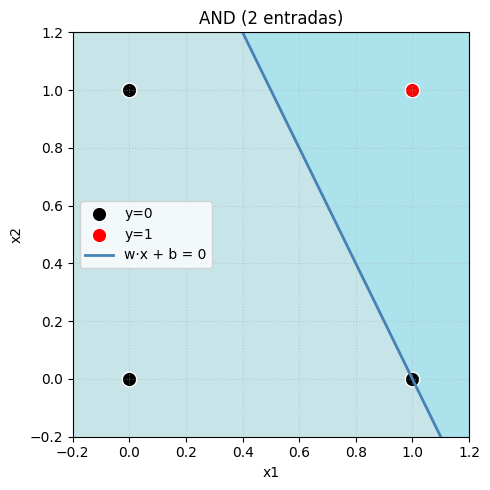

In [9]:
plot_decision_boundary(p_and2, X_and2, y_and2, "AND (2 entradas)")

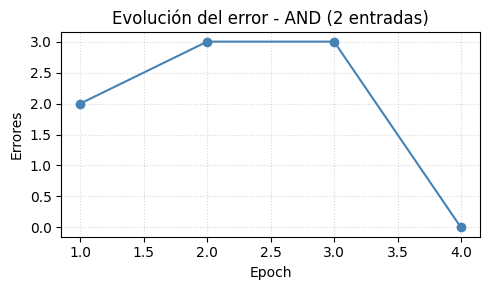

In [10]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(p_and2.errores_por_epoca) + 1), p_and2.errores_por_epoca, marker='o', color='steelblue')
plt.xlabel('Epoch')
plt.ylabel('Errores')
plt.title('Evolución del error - AND (2 entradas)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()


In [11]:
p_and2.errores_por_epoca

[2, 3, 3, 0]

In [12]:
from itertools import product
# AND 4 entradas
# Todas las combinaciones de 4 bits
X_and4 = [list(bits) for bits in product([0, 1], repeat=4)]
y_and4 = [1 if sum(bits) == 4 else 0 for bits in X_and4]

p_and4 = Perceptron(n_features=4, learning_rate=0.2, max_ciclos_entrenamiento=200)
ep_and4, _ = p_and4.entrenamiento(X_and4, y_and4)
print(f"Convergió en {ep_and4} épocas")
evaluate(p_and4, X_and4, y_and4, "AND (4 entradas)")

Convergió en 16 épocas

=== AND (4 entradas) ===
x=[0, 0, 0, 0] -> y_hat=0 (y=0) ✓
x=[0, 0, 0, 1] -> y_hat=0 (y=0) ✓
x=[0, 0, 1, 0] -> y_hat=0 (y=0) ✓
x=[0, 0, 1, 1] -> y_hat=0 (y=0) ✓
x=[0, 1, 0, 0] -> y_hat=0 (y=0) ✓
x=[0, 1, 0, 1] -> y_hat=0 (y=0) ✓
x=[0, 1, 1, 0] -> y_hat=0 (y=0) ✓
x=[0, 1, 1, 1] -> y_hat=0 (y=0) ✓
x=[1, 0, 0, 0] -> y_hat=0 (y=0) ✓
x=[1, 0, 0, 1] -> y_hat=0 (y=0) ✓
x=[1, 0, 1, 0] -> y_hat=0 (y=0) ✓
x=[1, 0, 1, 1] -> y_hat=0 (y=0) ✓
x=[1, 1, 0, 0] -> y_hat=0 (y=0) ✓
x=[1, 1, 0, 1] -> y_hat=0 (y=0) ✓
x=[1, 1, 1, 0] -> y_hat=0 (y=0) ✓
x=[1, 1, 1, 1] -> y_hat=1 (y=1) ✓
Accuracy: 16/16 = 1.00
weights: [0.8, 0.4000000000000001, 0.2, 0.2], bias: -1.5999999999999999


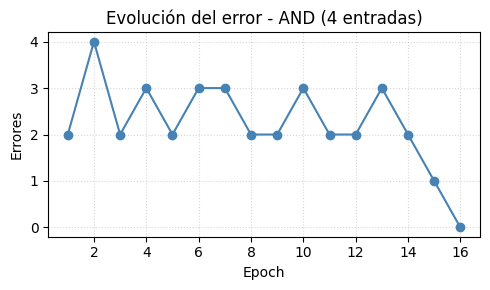

In [13]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(p_and4.errores_por_epoca) + 1), p_and4.errores_por_epoca, marker='o', color='steelblue')
plt.xlabel('Epoch')
plt.ylabel('Errores')
plt.title('Evolución del error - AND (4 entradas)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

In [14]:
# OR 2 entradas
X_or2 = [[0, 0], [0, 1], [1, 0], [1, 1]]
y_or2 = [0, 1, 1, 1]
p_or2 = Perceptron(n_features=2, learning_rate=0.2, max_ciclos_entrenamiento=100)
ep_or2, _ = p_or2.entrenamiento(X_or2, y_or2)
print(f'Convergió en {ep_or2} épocas')
evaluate(p_or2, X_or2, y_or2, 'OR (2 entradas)')

Convergió en 4 épocas

=== OR (2 entradas) ===
x=[0, 0] -> y_hat=0 (y=0) ✓
x=[0, 1] -> y_hat=1 (y=1) ✓
x=[1, 0] -> y_hat=1 (y=1) ✓
x=[1, 1] -> y_hat=1 (y=1) ✓
Accuracy: 4/4 = 1.00
weights: [0.2, 0.2], bias: -0.2


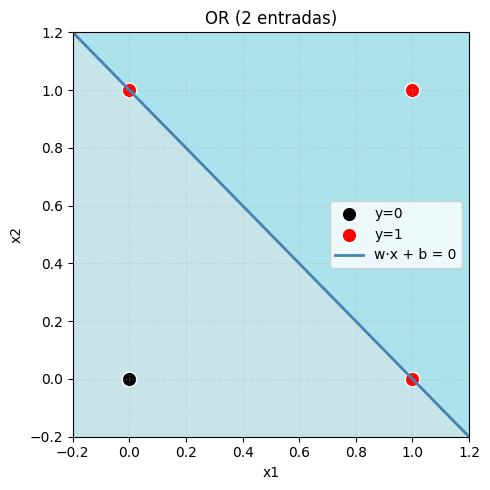

In [15]:
plot_decision_boundary(p_or2, X_or2, y_or2, 'OR (2 entradas)')

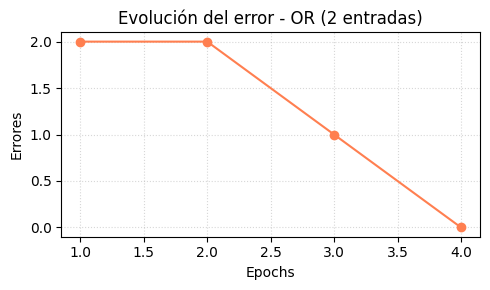

In [16]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(p_or2.errores_por_epoca) + 1), p_or2.errores_por_epoca, marker='o', color='coral')
plt.xlabel('Epochs')
plt.ylabel('Errores')
plt.title('Evolución del error - OR (2 entradas)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

In [17]:
p_or2.errores_por_epoca

[2, 2, 1, 0]

In [18]:
# OR 4 entradas
X_or4 = [list(bits) for bits in product([0, 1], repeat=4)]
y_or4 = [1 if any(bits) else 0 for bits in X_or4]
p_or4 = Perceptron(n_features=4, learning_rate=0.2, max_ciclos_entrenamiento=200)
ep_or4, _ = p_or4.entrenamiento(X_or4, y_or4)
print(f'Convergió en {ep_or4} épocas')
evaluate(p_or4, X_or4, y_or4, 'OR (4 entradas)')

Convergió en 6 épocas

=== OR (4 entradas) ===
x=[0, 0, 0, 0] -> y_hat=0 (y=0) ✓
x=[0, 0, 0, 1] -> y_hat=1 (y=1) ✓
x=[0, 0, 1, 0] -> y_hat=1 (y=1) ✓
x=[0, 0, 1, 1] -> y_hat=1 (y=1) ✓
x=[0, 1, 0, 0] -> y_hat=1 (y=1) ✓
x=[0, 1, 0, 1] -> y_hat=1 (y=1) ✓
x=[0, 1, 1, 0] -> y_hat=1 (y=1) ✓
x=[0, 1, 1, 1] -> y_hat=1 (y=1) ✓
x=[1, 0, 0, 0] -> y_hat=1 (y=1) ✓
x=[1, 0, 0, 1] -> y_hat=1 (y=1) ✓
x=[1, 0, 1, 0] -> y_hat=1 (y=1) ✓
x=[1, 0, 1, 1] -> y_hat=1 (y=1) ✓
x=[1, 1, 0, 0] -> y_hat=1 (y=1) ✓
x=[1, 1, 0, 1] -> y_hat=1 (y=1) ✓
x=[1, 1, 1, 0] -> y_hat=1 (y=1) ✓
x=[1, 1, 1, 1] -> y_hat=1 (y=1) ✓
Accuracy: 16/16 = 1.00
weights: [0.2, 0.2, 0.2, 0.2], bias: -0.2


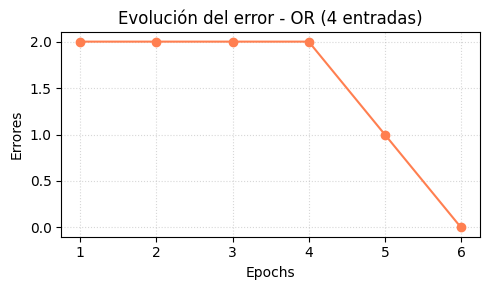

In [19]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, len(p_or4.errores_por_epoca) + 1), p_or4.errores_por_epoca, marker='o', color='coral')
plt.xlabel('Epochs')
plt.ylabel('Errores')
plt.title('Evolución del error - OR (4 entradas)')
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

# 2. Determine numéricamente cómo varía la capacidad del perceptrón simple en función del número de patrones enseñados. 

In [56]:
import random

def run_capacity_experiment(n_features: int, pattern_counts, trials: int = 100, seed: int = 42):
    rng = random.Random(seed)
    results = []
    for m in pattern_counts:
        successes = 0
        epochs_success = []
        for _ in range(trials):
            X = [[rng.choice([-1.0, 1.0]) for _ in range(n_features)] for _ in range(m)]
            y = [rng.choice([0, 1]) for _ in range(m)]
            perceptron = Perceptron(n_features=n_features, learning_rate=0.1, max_ciclos_entrenamiento=2000)
            epochs, _ = perceptron.entrenamiento(X, y)
            converged = perceptron.errores_por_epoca[-1] == 0
            if converged:
                successes += 1
                epochs_success.append(epochs)
        tasa_exito = successes / trials
        promedio_epochs = sum(epochs_success) / len(epochs_success) if epochs_success else None
        results.append({
            "patrones": m,
            "alpha": m / n_features,
            "tasa_exito": tasa_exito,
            "epochs_promedio": promedio_epochs
        })
    return results

pattern_counts = list(range(1, 21))
capacidad_resultados = run_capacity_experiment(n_features=5, pattern_counts=pattern_counts, trials=100, seed=123)

try:
    import pandas as pd
    capacidad_df = pd.DataFrame(capacidad_resultados)
    display(capacidad_df)
except ImportError:
    for row in capacidad_resultados:
        print(row)



,patrones,alpha,tasa_exito,epochs_promedio
0,1,0.2,1.00,1.520000
1,2,0.4,0.97,1.948454
2,3,0.6,0.93,2.172043
3,4,0.8,0.87,2.494253
4,5,1.0,0.80,2.862500
5,6,1.2,0.78,3.371795
6,7,1.4,0.66,4.075758
7,8,1.6,0.64,4.359375
8,9,1.8,0.45,4.822222
9,10,2.0,0.29,5.172414


In [57]:
def estimate_learning_rate_threshold(
    n_features: int,
    pattern_counts,
    learning_rates,
    success_threshold: float = 0.9,
    trials: int = 100,
    seed: int = 42
):
    rng = random.Random(seed)
    ordered_learning_rates = sorted(learning_rates, reverse=True)
    results = []
    for m in pattern_counts:
        datasets = [
            (
                [[rng.choice([-1.0, 1.0]) for _ in range(n_features)] for _ in range(m)],
                [rng.choice([0, 1]) for _ in range(m)]
            )
            for _ in range(trials)
        ]
        eta_star = None
        tasa_encontrada = 0.0
        for eta in ordered_learning_rates:
            successes = 0
            for X, y in datasets:
                perceptron = Perceptron(n_features=n_features, learning_rate=eta, max_ciclos_entrenamiento=2000)
                epochs, _ = perceptron.entrenamiento(X, y)
                if perceptron.errores_por_epoca[-1] == 0:
                    successes += 1
            tasa_exito = successes / trials
            if tasa_exito >= success_threshold:
                eta_star = eta
                tasa_encontrada = tasa_exito
                break
        results.append({
            "patrones": m,
            "eta_umbral": eta_star,
            "tasa_exito_umbral": tasa_encontrada,
            "threshold": success_threshold
        })
    return results


In [58]:
learning_rate_candidates = np.linspace(0.01, 1.0, 30)
eta_threshold_results = estimate_learning_rate_threshold(
    n_features=5,
    pattern_counts=pattern_counts,
    learning_rates=learning_rate_candidates,
    success_threshold=0.9,
    trials=60,
    seed=456
)

try:
    import pandas as pd
    eta_threshold_df = pd.DataFrame(eta_threshold_results)
    display(eta_threshold_df)
except ImportError:
    for row in eta_threshold_results:
        print(row)

,patrones,eta_umbral,tasa_exito_umbral,threshold
0,1,1.0,1.000000,0.9
1,2,1.0,0.966667,0.9
2,3,1.0,0.916667,0.9
3,4,1.0,0.916667,0.9
4,5,NaN,0.000000,0.9
5,6,NaN,0.000000,0.9
6,7,NaN,0.000000,0.9
7,8,NaN,0.000000,0.9
8,9,NaN,0.000000,0.9
9,10,NaN,0.000000,0.9


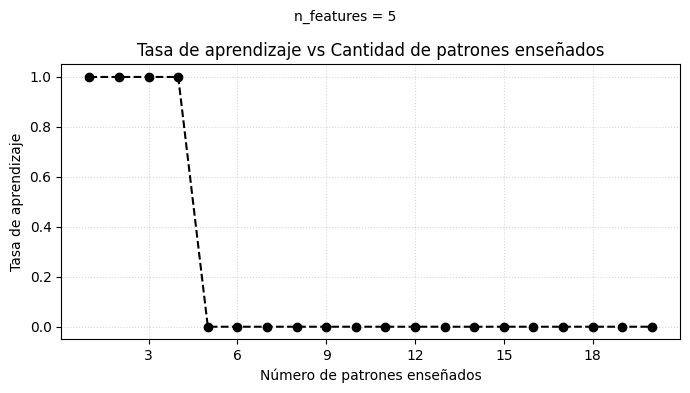

In [61]:
eta_values = [r["eta_umbral"] if r["eta_umbral"] is not None else 0.0 for r in eta_threshold_results]
plt.figure(figsize=(7, 4))
plt.plot(pattern_counts, eta_values, marker='o', linestyle='--', color='black')
plt.xlabel('Número de patrones enseñados')
plt.ylabel('Tasa de aprendizaje')
plt.title('Tasa de aprendizaje vs Cantidad de patrones enseñados')
plt.suptitle('n_features = 5', y=0.97, fontsize=10)
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle=':', alpha=0.5)
plt.tight_layout()
plt.show()

